In [1]:
%run flow_tools.py

In [2]:
from matplotlib.path import Path
from matplotlib import patches

In [3]:
folders = ['../data/20220816 - LCB Retry 24h/',
           '../data/20220817 - LCB Retry 48h/',
           '../data/20220818 - LCB Retry 72h/']

In [4]:
df = [load_data(folder, colnames = ['WellName', 'Effector', 'Target', 'Timepoint','Replicate', 'Plate']) for folder in folders]
df = pd.concat(df)

In [5]:
#remove all rows with values less than 0
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]

df2.loc[(df2['WellName']=='C02') &
        (df2['Plate']==3),:] = np.nan

#remove all rows with missing values
df2= df2.dropna()

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [6]:
event_counts = df2.groupby(['Plate', 'WellName'])['FSC-A'].count().reset_index()
event_counts['Row'] = event_counts['WellName'].apply(lambda x: x[0])
event_counts['Col'] = event_counts['WellName'].apply(lambda x: x[1:])
event_counts['PlateRow'] = event_counts['Plate'] + ' ' + event_counts['Row']

<AxesSubplot:xlabel='Col', ylabel='PlateRow'>

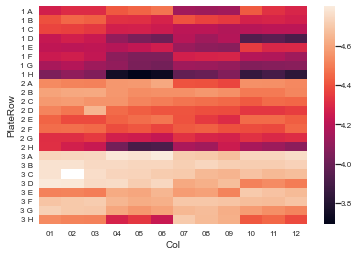

In [14]:
for_heatmap = event_counts.pivot_table(values='FSC-A', index='PlateRow', columns='Col')
sns.heatmap(np.log10(for_heatmap))

In [6]:
#define gate for FSC-A vs SSC-A
fsc_ssc_verts = [(4e4, 1e4),
              (1e5, 2.5e4),
              (2.75e5, 1e5),
              (2.75e5, 2.75e5),
              (1e5, 2.75e5),
              (4e4, 5e4),
              (4e4, 5e4),
              (4e4, 1e4)]
fsc_ssc_gate = Path(fsc_ssc_verts)

ssc_verts = [(0, 1e4),
              (2e5, 2e5),
              (2.7e5, 2e5),
              (2.7e5, 1.3e5),
              (1.25e5, 7.5e4),
              (1e4, 0),
              (0, 1e4)]
ssc_gate = Path(ssc_verts)

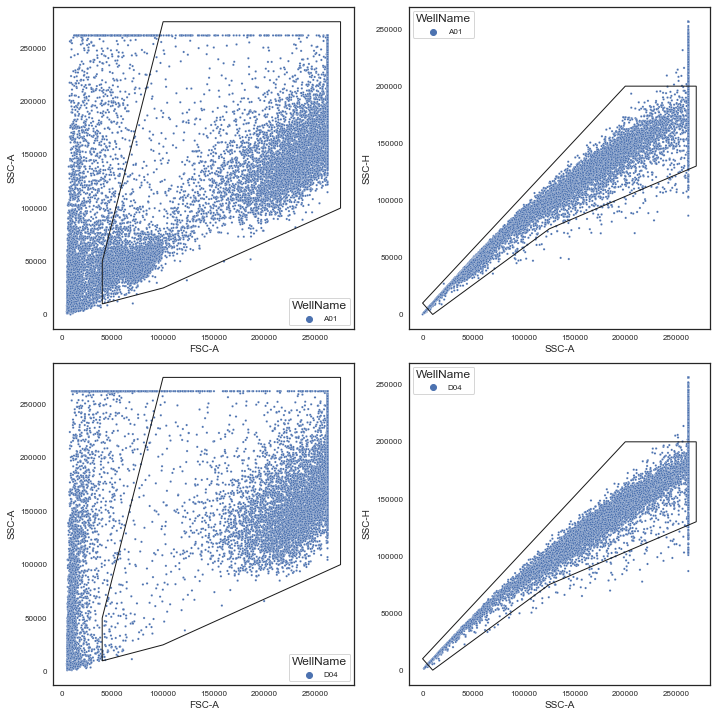

In [10]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A01'])) & (df2['Plate']=='1')], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A01']) & (df2['Plate']=='1')], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['D04']) & (df2['Plate']=='1')], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['D04']) & (df2['Plate']=='1')], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[0,0].add_patch(patch)
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[1,0].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[0,1].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[1,1].add_patch(patch)
plt.tight_layout()

In [7]:
#filter to gate
df2 = df2[fsc_ssc_gate.contains_points(df2[['FSC-A','SSC-A']].to_numpy())]
df2 = df2[ssc_gate.contains_points(df2[['SSC-A', 'SSC-H']].to_numpy())]
# # gate on singlets
# df2 = gate_density(df2, 0.1, x_var='SSC-A',y_var='SSC-H')

for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

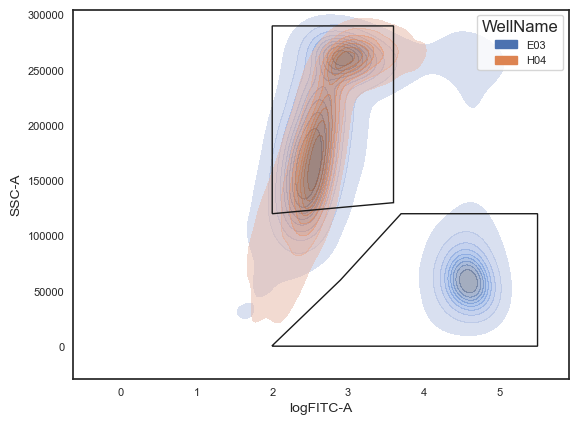

In [8]:
#define gate for FSC-A vs SSC-A
k562_verts = [(2, 1.2e5),
              (3.6, 1.3e5),
              (3.6, 2.9e5),
              (2, 2.9e5),
              (2, 2.5e5),
              (2, 1.2e5)]
k562_gate = Path(k562_verts)

tcell_verts = [(2, 1e2),
              (5.5, 1e2),
              (5.5, 1.2e5),
              (3.7, 1.2e5),
               (2.9, 6e4),
              (2, 6e2),
              (2, 1e2)]
tcell_gate = Path(tcell_verts)

parental_wells = df2[((df2['WellName'].isin(['H04'])) & (df2['Plate']=='3')) |
                     (df2['WellName'].isin(['E03']) & (df2['Plate']=='3'))]
fig, axs = plt.subplots(1,1)
sns.kdeplot(data=parental_wells, y='SSC-A', x='logFITC-A', fill=True, hue='WellName', alpha=0.5, ax=axs)
patch = patches.PathPatch(k562_gate, facecolor="None", edgecolor='k')
axs.add_patch(patch)
patch = patches.PathPatch(tcell_gate, facecolor="None", edgecolor='k')
axs.add_patch(patch)

In [9]:
target_filter = k562_gate.contains_points(df2[['logFITC-A','SSC-A']].to_numpy())
effector_filter = tcell_gate.contains_points(df2[['logFITC-A','SSC-A']].to_numpy())

df2['Type'] = 'Unknown'
df2.loc[target_filter, 'Type'] = 'Target'
df2.loc[effector_filter, 'Type'] = 'Effector'

In [10]:
expression_df = (df2[(df2['Effector']=='None') &
                     (df2['Timepoint']=='72h')]
                 .groupby(['Target','Replicate'])['FITC-A']
                 .median()
                 .reset_index())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


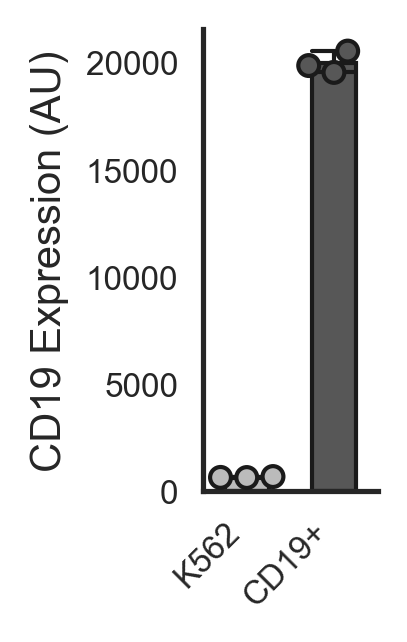

In [20]:
with sns.color_palette([grey, "#575757"]):
    fig, ax = plt.subplots(1,1,figsize=(0.75,2), dpi=300)
    g = sns.swarmplot(data=expression_df, x='Target', y='FITC-A', hue='Target',
                  order=['K562', 'CD19+'],
                  hue_order=['K562', 'CD19+'], 
                  edgecolor='k', linewidth=1)
    sns.barplot(data=expression_df, x='Target', y='FITC-A', hue='Target',
                  order=['K562', 'CD19+'],
                  hue_order=['K562', 'CD19+'], 
                estimator='mean',
            dodge=False, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
            err_kws={'linewidth': 1, 'color':'k'})
    g.legend().remove()
    g.set_ylabel('CD19 Expression (AU)')
    g.set_xlabel('')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.savefig(outputdir+'cd19-expression.pdf', bbox_inches='tight')

Text(0.5, 37.43999999999994, 'log <channel>')

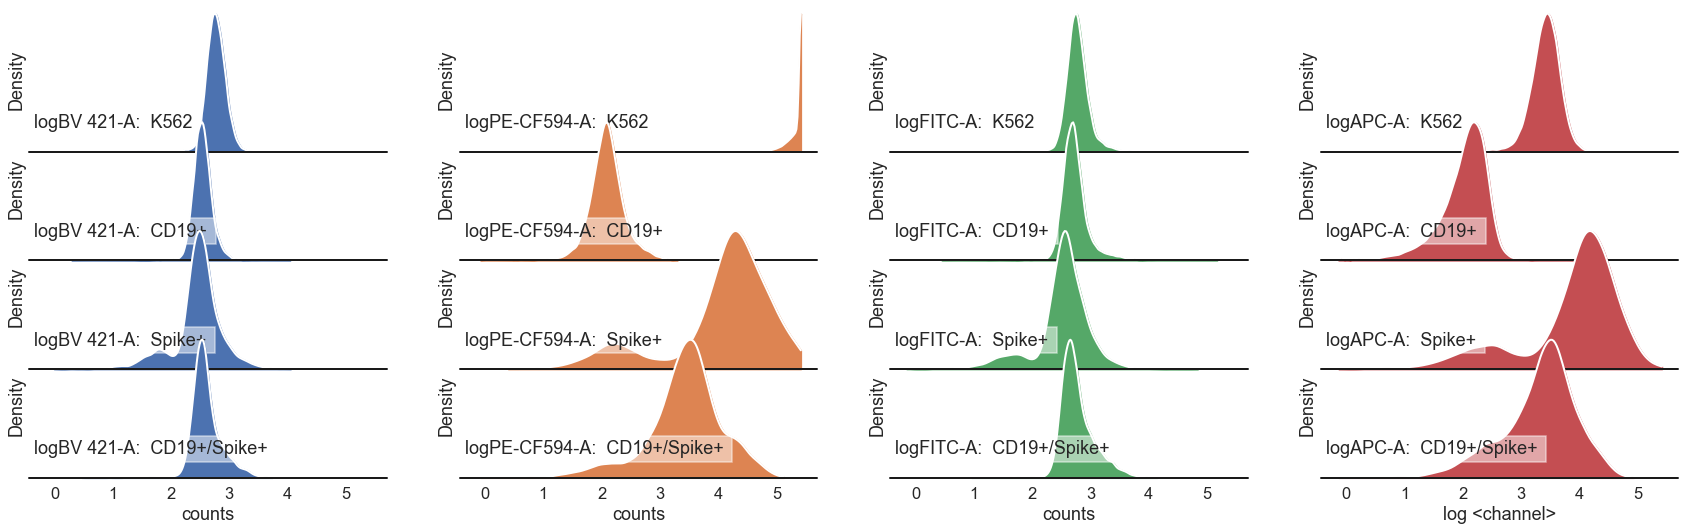

In [26]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logBV 421-A','logPE-CF594-A','logFITC-A', 'logAPC-A'], 
                       id_vars=['index','WellName','Target','Effector'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[(simplified_df["Effector"].isin(['None'])) &
                                     ~(simplified_df['Target'].isin(['None']))], 
                  row = 'Target', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

In [10]:
effector_order = ['Untransduced','LCB1', 'LCB3', 'LCB1-Short','LCB1-Long','LCB1-Rigid','CD19']
target_order = ['K562', 'CD19+', 'Spike+', 'CD19+/Spike+']
timepoint_order = ['24h', '48h', '72h']

In [23]:
activation_df = (df2[~(df2['Effector']=='None') &
                     (df2['Type']=='Effector')]
                 .groupby(['Effector','Target','Timepoint','Replicate','Plate'])['logAPC-A']
                 .mean()
                 .reset_index())

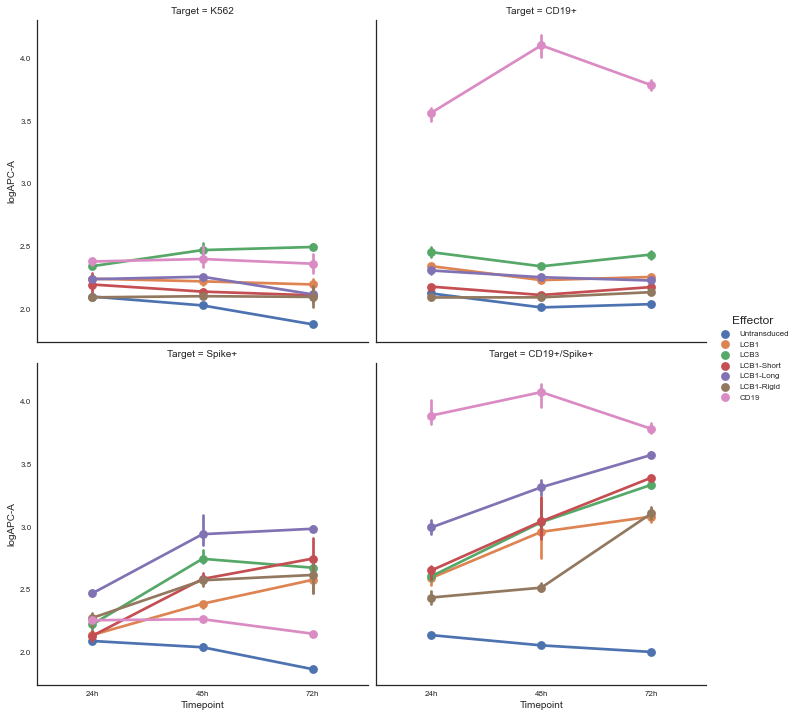

In [24]:
g = sns.catplot(data=activation_df, col='Target', x='Timepoint',y='logAPC-A',hue='Effector', col_wrap=2, kind='point', join=True, dodge=False,
               col_order=target_order, order=timepoint_order, hue_order=effector_order)

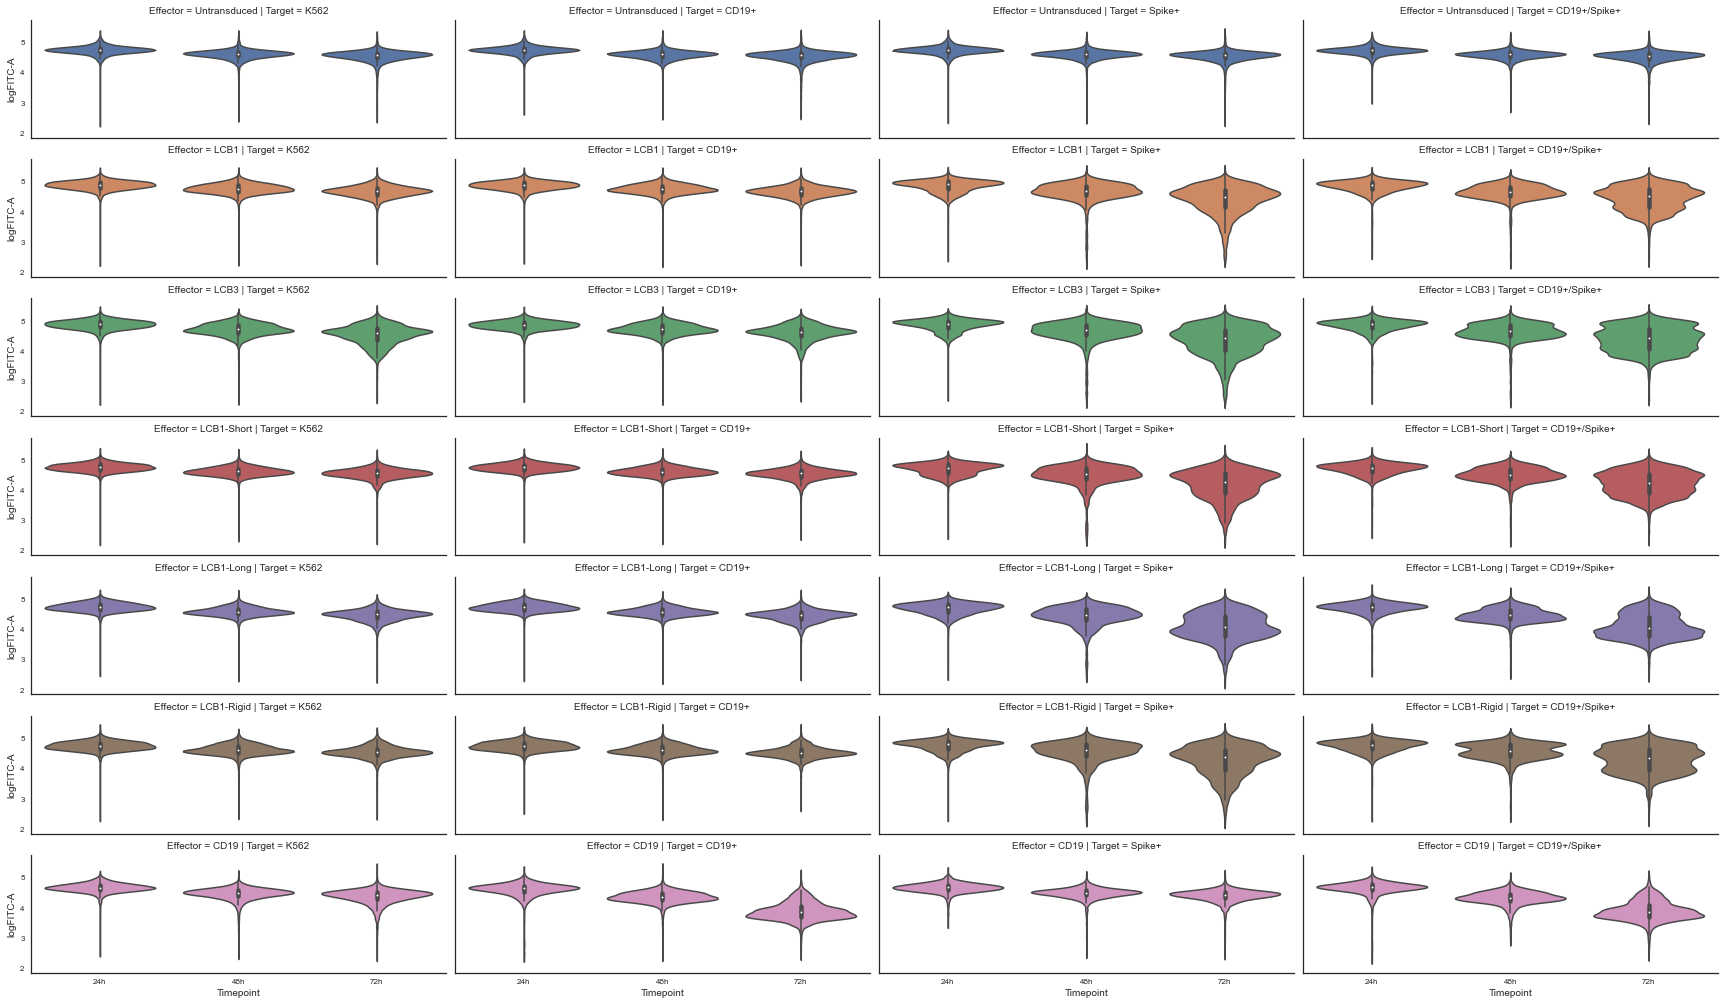

In [25]:
g = sns.catplot(data=df2[(df2['Type']=='Effector')], 
                col='Target', row='Effector', hue='Effector', x='Timepoint', y='logFITC-A', 
                aspect=3, height=2, kind='violin', estimator=np.median, dodge=False,
                hue_order=effector_order, order=timepoint_order,
                row_order=effector_order, col_order=target_order)

In [11]:
count_df = (df2.groupby(['WellName','Effector','Target','Timepoint','Replicate'])['Type']
                 .agg(Effectors=(lambda x: np.sum(x == 'Effector')),
                      Targets=(lambda x: np.sum(x == 'Target')))
                 .reset_index())

In [12]:
count_df['Lysis'] = np.nan
count_df['Fold Change From UnT'] = np.nan
for target in target_order:
    for timepoint in timepoint_order:
        target_filter = ((count_df['Target'] == target) & 
                         (count_df['Timepoint'] == timepoint))
        baseline = count_df[(count_df['Effector'] == 'Untransduced') &
                            target_filter]['Targets'].mean()
        count_df.loc[target_filter, 'Lysis'] = 100-(100*((count_df[target_filter]['Targets']/baseline)))
        unt_killing = count_df[(count_df['Effector'] == 'Untransduced') &
                               target_filter]['Lysis'].mean()
        for effector in effector_order:
            effector_filter = (target_filter &
                               (count_df['Effector'] == effector))
            count_df.loc[effector_filter, 'Fold Change From UnT'] = count_df[effector_filter]['Lysis']/unt_killing

In [13]:
count_df.loc[count_df['Effector']=='LCB1','Effector']='LCB1-CAR'
count_df.loc[count_df['Effector']=='CD19','Effector']='CD19-CAR'
count_df.loc[count_df['Effector']=='LCB3','Effector']='LCB3-CAR'

In [17]:
count_df[count_df['Timepoint'] == '72h'].groupby(['Effector','Target'])['Lysis'].agg(['mean','std'])

mean        std
Effector     Target                               
CD19-CAR     CD19+         9.627196e+01   0.536269
             CD19+/Spike+  9.250365e+01   0.795953
             K562         -5.083026e-01  19.509739
             Spike+       -1.628247e+01   3.534345
LCB1-CAR     CD19+         7.807260e+00   3.338974
             CD19+/Spike+  5.042394e+00   3.547923
             K562         -1.564737e-01   3.243811
             Spike+        4.295061e+01   6.461132
LCB1-Long    CD19+         1.194765e+01   3.269552
             CD19+/Spike+  3.765325e+01   6.995048
             K562         -2.514486e+00   2.472383
             Spike+        4.840847e+01   3.379782
LCB1-Rigid   CD19+         4.864905e+00   3.233571
             CD19+/Spike+  2.094338e+01   9.244014
             K562         -1.959241e+00   2.781748
             Spike+        4.515639e+01   5.728274
LCB1-Short   CD19+        -2.233659e+00   1.580399
             CD19+/Spike+  2.756262e+01   5.229768
             K562         -3.850202e+00   1.306842
             Spike+        4.221903e+01   3.634645
LCB3-CAR     CD19+         2.004598e+01   3.423235
             CD19+/Spike+  3.133028e+01   3.029003
             K562          1.376590e+01   4.633774
             Spike+        3.787649e+01   6.900736
None         CD19+         9.850668e+01   0.250662
             CD19+/Spike+  9.822629e+01   0.196765
             K562         -2.859202e+01   6.821191
             Spike+        4.328189e+01   5.216538
Untransduced CD19+        -4.736952e-15   1.951156
             CD19+/Spike+  4.736952e-15   9.070553
             K562         -9.473903e-15   0.927708
             Spike+        4.736952e-15   2.098107

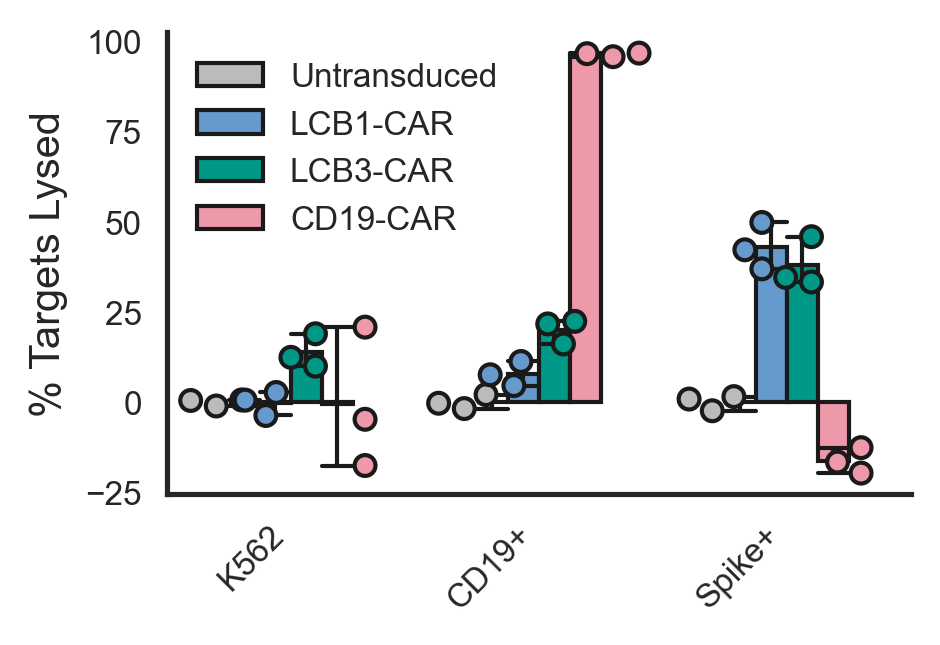

In [17]:
effectors = ['Untransduced','LCB1-CAR','LCB3-CAR','CD19-CAR']
targets = ['K562','CD19+','Spike+']
with sns.color_palette([grey, light_blue, teal, light_red]):
    fig, ax = plt.subplots(1,1,figsize=(3.2,2), dpi=300)
    g = sns.swarmplot(data=count_df[(count_df['Timepoint']=='72h') &
                                      (count_df['Effector'].isin(effectors))],
                      x='Target', y='Lysis', hue='Effector',
                  order=targets,
                  hue_order=effectors, 
                  edgecolor='k', linewidth=1, dodge=True)
    sns.barplot(data=count_df[(count_df['Timepoint']=='72h') &
                                      (count_df['Effector'].isin(effectors))],
                      x='Target', y='Lysis', hue='Effector',
                  order=targets,
                  hue_order=effectors,
                estimator='mean', 
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
            err_kws={'linewidth': 1, 'color':'k'})
    g.legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    order = [4,5,6,7]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='upper left')
    g.set_ylabel('% Targets Lysed')
    g.set_xlabel('')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.savefig(outputdir+'cd19-comparison.pdf', bbox_inches='tight')

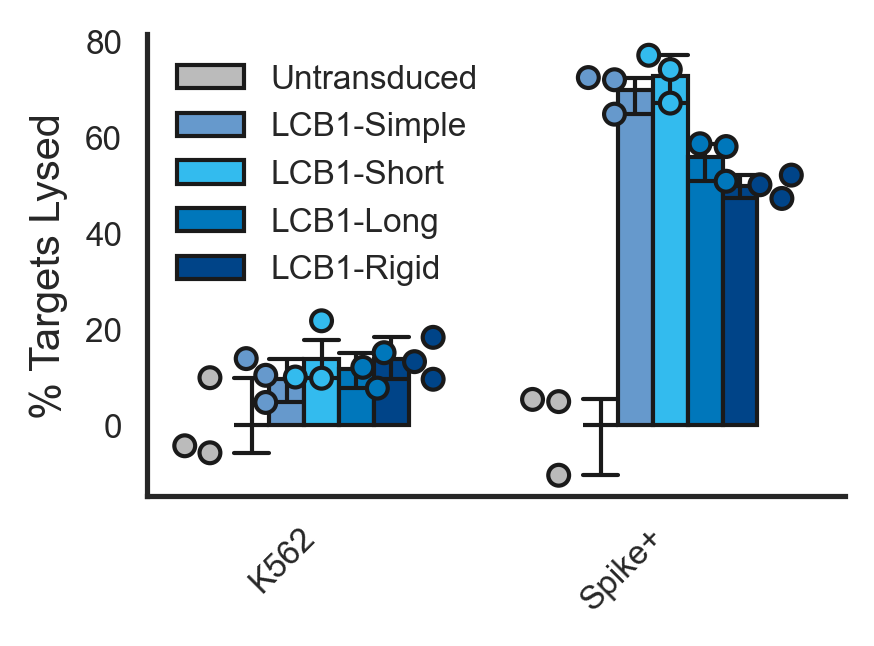

In [18]:
count_df.loc[count_df['Effector']=='LCB1-CAR','Effector']='LCB1-Simple'
effectors = ['Untransduced','LCB1-Simple','LCB1-Short','LCB1-Long', 'LCB1-Rigid']
targets = ['K562', 'Spike+']
with sns.color_palette([grey, light_blue, cyan, blue, dark_blue]):
    fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
    g = sns.swarmplot(data=count_df[(count_df['Timepoint']=='24h') &
                                      (count_df['Effector'].isin(effectors))],
                      x='Target', y='Lysis', hue='Effector',
                  order=targets,
                  hue_order=effectors, 
                  edgecolor='k', linewidth=1, dodge=True)
    sns.barplot(data=count_df[(count_df['Timepoint']=='24h') &
                                      (count_df['Effector'].isin(effectors))],
                      x='Target', y='Lysis', hue='Effector',
                  order=targets,
                  hue_order=effectors, 
                estimator='mean',
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
            err_kws={'linewidth': 1, 'color':'k'})
    g.legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    order = [5, 6, 7, 8, 9]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='upper left')
    g.set_ylabel('% Targets Lysed')
    g.set_xlabel('')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.savefig(outputdir+'linker-killing-comparison.pdf', bbox_inches='tight')

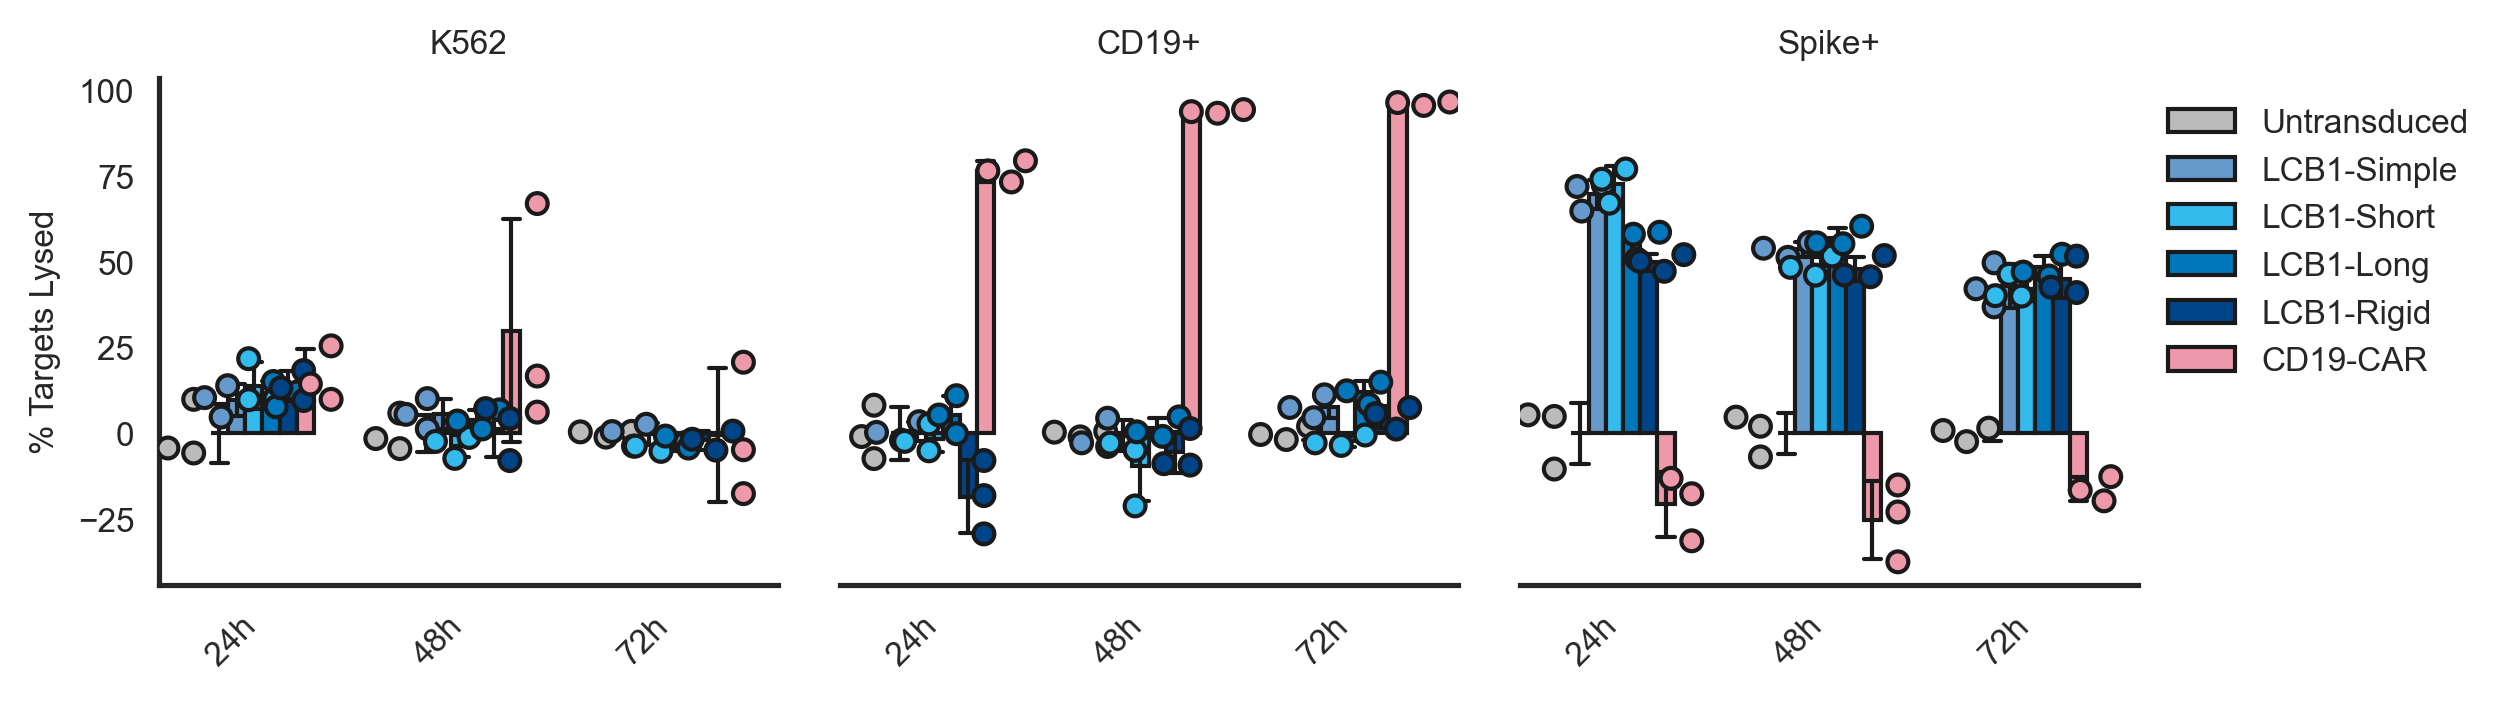

In [19]:
effectors = ['Untransduced','LCB1-Simple','LCB1-Short','LCB1-Long', 'LCB1-Rigid', 'CD19-CAR']
targets = ['K562', 'CD19+', 'Spike+']
colors = [grey, light_blue, cyan, blue, dark_blue, light_red]
g = sns.catplot(data=count_df, col='Target', x='Timepoint',y='Lysis',hue='Effector', kind='swarm',
                col_order=targets, order=timepoint_order, hue_order=effectors, 
                edgecolor='k', linewidth=1, dodge=True, palette=colors)
g.map_dataframe(sns.barplot, x='Timepoint', y='Lysis',
                hue_order=effectors, errorbar='sd', hue='Effector',palette=colors,
                dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                estimator='mean',
                err_kws={'linewidth': 1, 'color':'k'})
g.figure.set_size_inches(7.5,2)
g.figure.set_dpi(300)
g.set_xlabels('')
g.set_xticklabels(rotation=45, ha='right', size=SMALL_SIZE)
g.fig.subplots_adjust(wspace=0.1)
g.set_titles(col_template='{col_name}', size=SMALL_SIZE)
g.legend.remove()
handles, labels = g.axes.flat[0].get_legend_handles_labels()
order = [0,1,2,3,4,5]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, bbox_to_anchor=[1,1])
for ax in g.axes.flat[1:]:
    ax.spines[['left']].set_visible(False)
g.set_ylabels('% Targets Lysed', size=SMALL_SIZE)
plt.savefig(outputdir+'timecourse_killing.pdf', bbox_inches='tight')